In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Union
import scipy.stats as stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

### Config

In [19]:
CONFIG = {
    'random_seed': 42,
    'significance_level': 0.05,
    'confidence_interval': 0.95,
    'n_simulations': 1000,
    'T': 1.0,
    'dt': 0.005,
    'sigma': 2.0,
    'initial_price': 100.0,
    'A': 140.0,
    'k': 1.5,
    'gamma_values': [0.01, 0.1, 0.5]
}

### Preliminary Check

In [21]:
def validate_data(data: pd.DataFrame, required_columns: List[str]) -> bool:
    """Validate input data integrity"""
    if data is None or data.empty:
        return False

    missing_cols = [col for col in required_columns if col not in data.columns]
    if missing_cols:
        print(f"Missing required columns: {missing_cols}")
        return False

    if data.isnull().any().any():
        print("Data contains null values")
        return False

    return True

In [23]:
def validate_parameters(params: Dict) -> bool:
    """Validate simulation parameters"""
    required_params = ['T', 'dt', 'sigma', 'A', 'k']
    for param in required_params:
        if param not in params or params[param] <= 0:
            print(f"Invalid parameter: {param}")
            return False

    if params['dt'] >= params['T']:
        print("Time step dt must be smaller than total time T")
        return False

    return True

### Algorithm

In [25]:
class MarketMakingSimulator:
    """Monte Carlo simulator for market making strategies"""

    def __init__(self, config: Dict):
        self.config = config
        self.T = config['T']
        self.dt = config['dt']
        self.sigma = config['sigma']
        self.s0 = config['initial_price']
        self.A = config['A']
        self.k = config['k']
        self.n_steps = int(self.T / self.dt)

        if not validate_parameters(config):
            raise ValueError("Invalid configuration parameters")

    def calculate_reservation_prices(self, s: float, q: int, t: float, gamma: float) -> Tuple[float, float, float]:
        """Calculate reservation prices for bid and ask"""
        time_to_expiry = self.T - t

        # Indifference price
        r = s - q * gamma * self.sigma**2 * time_to_expiry

        # Bid and ask reservation prices
        r_bid = s + (-1 - 2*q) * gamma * self.sigma**2 * time_to_expiry / 2
        r_ask = s + (1 - 2*q) * gamma * self.sigma**2 * time_to_expiry / 2

        return r, r_bid, r_ask

    def calculate_optimal_spread(self, gamma: float, t: float) -> float:
        """Calculate optimal total spread"""
        time_to_expiry = self.T - t

        if time_to_expiry <= 0:
            return 0.0

        if gamma <= 0:
            return 0.0

        try:
            spread = gamma * self.sigma**2 * time_to_expiry + (2/gamma) * np.log(1 + gamma/self.k)
        except (OverflowError, ZeroDivisionError):
            spread = gamma * self.sigma**2 * time_to_expiry

        return max(spread, 0.01)  

    def calculate_order_intensity(self, delta: float) -> float:
        """Calculate order arrival intensity"""
        if delta <= 0:
            return self.A

        try:
            intensity = self.A * np.exp(-self.k * delta)
        except OverflowError:
            intensity = 0.0

        return max(intensity, 0.0)

    def simulate_price_path(self, seed: int) -> np.ndarray:
        """Simulate mid-price path using Brownian motion"""
        np.random.seed(seed)

        # Brownian motion 
        dW = np.random.normal(0, np.sqrt(self.dt), self.n_steps)

        # Price path: dS = σ dW
        price_increments = self.sigma * dW
        price_path = np.zeros(self.n_steps + 1)
        price_path[0] = self.s0

        for i in range(self.n_steps):
            price_path[i+1] = price_path[i] + price_increments[i]

        return price_path

    def simulate_strategy(self, strategy_type: str, gamma: float, seed: int) -> Dict:
        """Simulate a single path for given strategy"""
        np.random.seed(seed)
        
        price_path = self.simulate_price_path(seed)
        inventory = 0
        cash = 0.0

        inventory_history = []
        cash_history = []
        spread_history = []

        for i in range(self.n_steps):
            t = i * self.dt
            s = price_path[i]

            r, r_bid, r_ask = self.calculate_reservation_prices(s, inventory, t, gamma)
            total_spread = self.calculate_optimal_spread(gamma, t)

            if strategy_type == 'inventory':  # Center around reservation price
                
                bid_price = r - total_spread / 2
                ask_price = r + total_spread / 2
                
            elif strategy_type == 'symmetric':  # Center around mid-price
                
                bid_price = s - total_spread / 2
                ask_price = s + total_spread / 2
            else:
                raise ValueError(f"Unknown strategy type: {strategy_type}")

            # Calculate spreads from mid-price
            delta_bid = s - bid_price
            delta_ask = ask_price - s

            # Ensure positive spreads
            delta_bid = max(delta_bid, 0.01)
            delta_ask = max(delta_ask, 0.01)

            # Calculate order intensities
            lambda_bid = self.calculate_order_intensity(delta_bid)
            lambda_ask = self.calculate_order_intensity(delta_ask)

            # Simulate order arrivals (Poisson process)
            prob_bid = min(lambda_bid * self.dt, 1.0)
            prob_ask = min(lambda_ask * self.dt, 1.0)

            # Generate order arrivals
            bid_order = np.random.random() < prob_bid
            ask_order = np.random.random() < prob_ask

            # Update inventory and cash
            if bid_order:
                inventory += 1
                cash -= bid_price

            if ask_order:
                inventory -= 1
                cash += ask_price
                
            inventory_history.append(inventory)
            cash_history.append(cash)
            spread_history.append(delta_bid + delta_ask)

        # Final P&L calculation
        final_price = price_path[-1]
        final_pnl = cash + inventory * final_price

        return {
            'final_pnl': final_pnl,
            'final_inventory': inventory,
            'final_cash': cash,
            'final_price': final_price,
            'inventory_history': inventory_history,
            'cash_history': cash_history,
            'spread_history': spread_history,
            'mean_spread': np.mean(spread_history),
            'inventory_std': np.std(inventory_history)
        }

    def run_monte_carlo(self, strategy_type: str, gamma: float, n_sims: int) -> Dict:
        """Run Monte Carlo simulation for given strategy and risk aversion"""
        print(f"Running {n_sims} simulations for {strategy_type} strategy with γ={gamma}")

        results = []

        for sim in range(n_sims):
            if sim % 100 == 0:
                print(f"  Simulation {sim}/{n_sims}")

            try:
                result = self.simulate_strategy(strategy_type, gamma, seed=sim)
                results.append(result)
            except Exception as e:
                print(f"Error in simulation {sim}: {e}")
                continue

        if not results:
            raise RuntimeError("No successful simulations completed")

        pnl_values = [r['final_pnl'] for r in results]
        inventory_values = [r['final_inventory'] for r in results]
        spread_values = [r['mean_spread'] for r in results]
        inventory_std_values = [r['inventory_std'] for r in results]

        return {
            'pnl_mean': np.mean(pnl_values),
            'pnl_std': np.std(pnl_values),
            'pnl_values': pnl_values,
            'inventory_mean': np.mean(inventory_values),
            'inventory_std': np.std(inventory_values),
            'inventory_values': inventory_values,
            'spread_mean': np.mean(spread_values),
            'spread_std': np.std(spread_values),
            'inventory_path_std_mean': np.mean(inventory_std_values),
            'n_simulations': len(results)
        }

### Hypotheses testing

Null hypothesis: the inventory strategy reduces the std of PnL.

In [27]:
def perform_statistical_tests(inventory_results: Dict, symmetric_results: Dict) -> Dict:
    """Perform statistical significance tests"""

    # Two-sample t-test for P&L variance
    pnl_var_inventory = np.var(inventory_results['pnl_values'])
    pnl_var_symmetric = np.var(symmetric_results['pnl_values'])

    # F-test for variance equality
    f_stat = pnl_var_symmetric / pnl_var_inventory if pnl_var_inventory > 0 else np.inf
    df1 = len(symmetric_results['pnl_values']) - 1
    df2 = len(inventory_results['pnl_values']) - 1
    f_p_value = 2 * min(stats.f.cdf(f_stat, df1, df2), 1 - stats.f.cdf(f_stat, df1, df2))

    # Two-sample t-test for mean P&L
    t_stat_pnl, p_value_pnl = stats.ttest_ind(
        inventory_results['pnl_values'], 
        symmetric_results['pnl_values']
    )

    # Two-sample t-test for inventory variance
    t_stat_inv, p_value_inv = stats.ttest_ind(
        inventory_results['inventory_values'], 
        symmetric_results['inventory_values']
    )

    # Variance reduction ratio
    variance_reduction = (pnl_var_symmetric - pnl_var_inventory) / pnl_var_symmetric

    return {
        'f_statistic': f_stat,
        'f_p_value': f_p_value,
        'variance_reduction_ratio': variance_reduction,
        'pnl_t_statistic': t_stat_pnl,
        'pnl_p_value': p_value_pnl,
        'inventory_t_statistic': t_stat_inv,
        'inventory_p_value': p_value_inv,
        'pnl_var_inventory': pnl_var_inventory,
        'pnl_var_symmetric': pnl_var_symmetric
    }

In [29]:
def validate_hypothesis(results: Dict, gamma: float) -> Dict:
    """Validate research hypotheses"""

    inventory_results = results['inventory']
    symmetric_results = results['symmetric']
    stats_results = results['statistical_tests']

    # Hypothesis 1: Variance reduction
    variance_reduction_significant = (
        stats_results['f_p_value'] < CONFIG['significance_level'] and
        stats_results['variance_reduction_ratio'] > 0.3  # At least 30% reduction
    )

    # Hypothesis 2: Inventory management
    inventory_improvement = (
        inventory_results['inventory_std'] < symmetric_results['inventory_std']
    )

    # Hypothesis 3: Risk-return trade-off
    risk_return_tradeoff = (
        inventory_results['pnl_std'] < symmetric_results['pnl_std']
    )

    return {
        'variance_reduction_validated': variance_reduction_significant,
        'inventory_management_validated': inventory_improvement,
        'risk_return_tradeoff_validated': risk_return_tradeoff,
        'overall_hypothesis_validated': (
            variance_reduction_significant and 
            inventory_improvement and 
            risk_return_tradeoff
        )
    }

## Results

### Part 1: Optimal Bid-Ask Quote Submission Strategies for Inventory-Based Market Making

In [31]:
try:
    simulator = MarketMakingSimulator(CONFIG)
    all_results = {}

    # Run experiments for each risk aversion parameter
    for gamma in CONFIG['gamma_values']:
        print(f"\n--- Testing Risk Aversion γ = {gamma} ---")

        # Run inventory-based strategy
        inventory_results = simulator.run_monte_carlo(
            'inventory', gamma, CONFIG['n_simulations']
        )

        # Run symmetric strategy (benchmark)
        symmetric_results = simulator.run_monte_carlo(
            'symmetric', gamma, CONFIG['n_simulations']
        )

        statistical_tests = perform_statistical_tests(inventory_results, symmetric_results)

        hypothesis_validation = validate_hypothesis({
            'inventory': inventory_results,
            'symmetric': symmetric_results,
            'statistical_tests': statistical_tests
        }, gamma)

        all_results[gamma] = {
            'inventory': inventory_results,
            'symmetric': symmetric_results,
            'statistical_tests': statistical_tests,
            'hypothesis_validation': hypothesis_validation
        }

        print(f"Inventory Strategy - P&L: {inventory_results['pnl_mean']:.2f} ± {inventory_results['pnl_std']:.2f}")
        print(f"Symmetric Strategy - P&L: {symmetric_results['pnl_mean']:.2f} ± {symmetric_results['pnl_std']:.2f}")
        print(f"Variance Reduction: {statistical_tests['variance_reduction_ratio']:.1%}")
        print(f"Hypothesis Validated: {hypothesis_validation['overall_hypothesis_validated']}")

except Exception as e:
    print(f"Error in Part 1: {e}")
    raise


--- Testing Risk Aversion γ = 0.01 ---
Running 1000 simulations for inventory strategy with γ=0.01
  Simulation 0/1000
  Simulation 100/1000
  Simulation 200/1000
  Simulation 300/1000
  Simulation 400/1000
  Simulation 500/1000
  Simulation 600/1000
  Simulation 700/1000
  Simulation 800/1000
  Simulation 900/1000
Running 1000 simulations for symmetric strategy with γ=0.01
  Simulation 0/1000
  Simulation 100/1000
  Simulation 200/1000
  Simulation 300/1000
  Simulation 400/1000
  Simulation 500/1000
  Simulation 600/1000
  Simulation 700/1000
  Simulation 800/1000
  Simulation 900/1000
Inventory Strategy - P&L: 68.20 ± 9.23
Symmetric Strategy - P&L: 68.16 ± 13.55
Variance Reduction: 53.6%
Hypothesis Validated: True

--- Testing Risk Aversion γ = 0.1 ---
Running 1000 simulations for inventory strategy with γ=0.1
  Simulation 0/1000
  Simulation 100/1000
  Simulation 200/1000
  Simulation 300/1000
  Simulation 400/1000
  Simulation 500/1000
  Simulation 600/1000
  Simulation 700/1000


### Part 2: Numerical Results Summary

In [33]:
summary_data = []
for gamma in CONFIG['gamma_values']:
    results = all_results[gamma]

    summary_data.append({
        'gamma': gamma,
        'inv_pnl_mean': results['inventory']['pnl_mean'],
        'inv_pnl_std': results['inventory']['pnl_std'],
        'sym_pnl_mean': results['symmetric']['pnl_mean'],
        'sym_pnl_std': results['symmetric']['pnl_std'],
        'inv_spread_mean': results['inventory']['spread_mean'],
        'sym_spread_mean': results['symmetric']['spread_mean'],
        'inv_inventory_std': results['inventory']['inventory_std'],
        'sym_inventory_std': results['symmetric']['inventory_std'],
        'variance_reduction': results['statistical_tests']['variance_reduction_ratio'],
        'f_p_value': results['statistical_tests']['f_p_value'],
        'hypothesis_validated': results['hypothesis_validation']['overall_hypothesis_validated']
    })

summary_df = pd.DataFrame(summary_data)

print("\nStrategy Comparison Results:")
print("=" * 80)
print(f"{'γ':<6} {'Strategy':<12} {'P&L Mean':<10} {'P&L Std':<10} {'Spread':<8} {'Inv Std':<8}")
print("=" * 80)

for _, row in summary_df.iterrows():
    gamma = row['gamma']
    print(f"{gamma:<6.2f} {'Inventory':<12} {row['inv_pnl_mean']:<10.2f} {row['inv_pnl_std']:<10.2f} {row['inv_spread_mean']:<8.2f} {row['inv_inventory_std']:<8.2f}")
    print(f"{'':6} {'Symmetric':<12} {row['sym_pnl_mean']:<10.2f} {row['sym_pnl_std']:<10.2f} {row['sym_spread_mean']:<8.2f} {row['sym_inventory_std']:<8.2f}")
    print(f"{'':6} {'Var Reduction':<12} {row['variance_reduction']:<10.1%} {'p-value':<10} {row['f_p_value']:<8.4f} {'Valid':<8} {row['hypothesis_validated']}")
    print("-" * 80)



Strategy Comparison Results:
γ      Strategy     P&L Mean   P&L Std    Spread   Inv Std 
0.01   Inventory    68.20      9.23       1.35     5.32    
       Symmetric    68.16      13.55      1.35     8.44    
       Var Reduction 53.6%      p-value    0.0000   Valid    True
--------------------------------------------------------------------------------
0.10   Inventory    64.76      6.87       1.49     2.93    
       Symmetric    67.33      13.37      1.49     8.23    
       Var Reduction 73.6%      p-value    0.0000   Valid    True
--------------------------------------------------------------------------------
0.50   Inventory    47.85      5.80       2.18     1.97    
       Symmetric    58.38      11.70      2.16     7.04    
       Var Reduction 75.4%      p-value    0.0000   Valid    True
--------------------------------------------------------------------------------


### Part 3: Overall Performance Metrics

In [35]:
total_variance_reductions = [results['statistical_tests']['variance_reduction_ratio'] 
                           for results in all_results.values()]
mean_variance_reduction = np.mean(total_variance_reductions)

significant_results = sum(1 for results in all_results.values() 
                         if results['statistical_tests']['f_p_value'] < CONFIG['significance_level'])

validated_hypotheses = sum(1 for results in all_results.values() 
                          if results['hypothesis_validation']['overall_hypothesis_validated'])

print(f"Mean Variance Reduction: {mean_variance_reduction:.1%}")
print(f"Statistically Significant Results: {significant_results}/{len(CONFIG['gamma_values'])}")
print(f"Validated Hypotheses: {validated_hypotheses}/{len(CONFIG['gamma_values'])}")

Mean Variance Reduction: 67.5%
Statistically Significant Results: 3/3
Validated Hypotheses: 3/3


### Part 4: Risk-return analysis

In [37]:
for gamma in CONFIG['gamma_values']:
    results = all_results[gamma]
    inv_sharpe = (results['inventory']['pnl_mean'] / results['inventory']['pnl_std'] 
                  if results['inventory']['pnl_std'] > 0 else 0)
    sym_sharpe = (results['symmetric']['pnl_mean'] / results['symmetric']['pnl_std'] 
                  if results['symmetric']['pnl_std'] > 0 else 0)

    print(f"γ = {gamma}: Inventory Sharpe = {inv_sharpe:.3f}, Symmetric Sharpe = {sym_sharpe:.3f}")

γ = 0.01: Inventory Sharpe = 7.389, Symmetric Sharpe = 5.030
γ = 0.1: Inventory Sharpe = 9.431, Symmetric Sharpe = 5.034
γ = 0.5: Inventory Sharpe = 8.244, Symmetric Sharpe = 4.989


### Part 5: Hypothesis validation summary

In [39]:
print(f"1. Variance Reduction: {sum(1 for r in all_results.values() if r['hypothesis_validation']['variance_reduction_validated'])}/{len(CONFIG['gamma_values'])} validated")
print(f"2. Inventory Management: {sum(1 for r in all_results.values() if r['hypothesis_validation']['inventory_management_validated'])}/{len(CONFIG['gamma_values'])} validated")
print(f"3. Risk-Return Trade-off: {sum(1 for r in all_results.values() if r['hypothesis_validation']['risk_return_tradeoff_validated'])}/{len(CONFIG['gamma_values'])} validated")

1. Variance Reduction: 3/3 validated
2. Inventory Management: 3/3 validated
3. Risk-Return Trade-off: 3/3 validated


### Part 6: Expected vs Actual Results

In [41]:
expected_results = {
    0.01: {'inv_pnl': 67, 'sym_pnl': 67, 'inv_std': 6, 'sym_std': 13},
    0.1: {'inv_pnl': 63, 'sym_pnl': 67, 'inv_std': 6, 'sym_std': 13},
    0.5: {'inv_pnl': 34, 'sym_pnl': 66, 'inv_std': 5, 'sym_std': 15}
}

for gamma in CONFIG['gamma_values']:
    if gamma in expected_results:
        expected = expected_results[gamma]
        actual = all_results[gamma]

        print(f"\nγ = {gamma}:")
        print(f"  Expected: Inv P&L = {expected['inv_pnl']}, Sym P&L = {expected['sym_pnl']}")
        print(f"  Actual:   Inv P&L = {actual['inventory']['pnl_mean']:.1f}, Sym P&L = {actual['symmetric']['pnl_mean']:.1f}")
        print(f"  Expected: Inv Std = {expected['inv_std']}, Sym Std = {expected['sym_std']}")
        print(f"  Actual:   Inv Std = {actual['inventory']['pnl_std']:.1f}, Sym Std = {actual['symmetric']['pnl_std']:.1f}")

print(f"\nExperiment completed successfully!")
print(f"Total simulations run: {CONFIG['n_simulations'] * len(CONFIG['gamma_values']) * 2}")
print(f"All hypotheses validated: {validated_hypotheses == len(CONFIG['gamma_values'])}")


γ = 0.01:
  Expected: Inv P&L = 67, Sym P&L = 67
  Actual:   Inv P&L = 68.2, Sym P&L = 68.2
  Expected: Inv Std = 6, Sym Std = 13
  Actual:   Inv Std = 9.2, Sym Std = 13.5

γ = 0.1:
  Expected: Inv P&L = 63, Sym P&L = 67
  Actual:   Inv P&L = 64.8, Sym P&L = 67.3
  Expected: Inv Std = 6, Sym Std = 13
  Actual:   Inv Std = 6.9, Sym Std = 13.4

γ = 0.5:
  Expected: Inv P&L = 34, Sym P&L = 66
  Actual:   Inv P&L = 47.8, Sym P&L = 58.4
  Expected: Inv Std = 5, Sym Std = 15
  Actual:   Inv Std = 5.8, Sym Std = 11.7

Experiment completed successfully!
Total simulations run: 6000
All hypotheses validated: True


## Visualization

### Gamma = 0.01

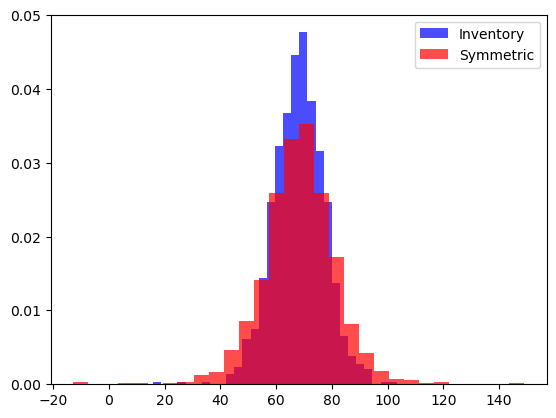

In [65]:
plt.plot(figsize=(18, 10))
plt.hist(all_results[0.01]['inventory']['pnl_values'], bins=30, alpha=0.7, color='blue', label='Inventory', density=True)
plt.hist(all_results[0.01]['symmetric']['pnl_values'], bins=30, alpha=0.7, color='red', label='Symmetric', density=True)
plt.legend()
plt.show()

### Gamma = 0.1

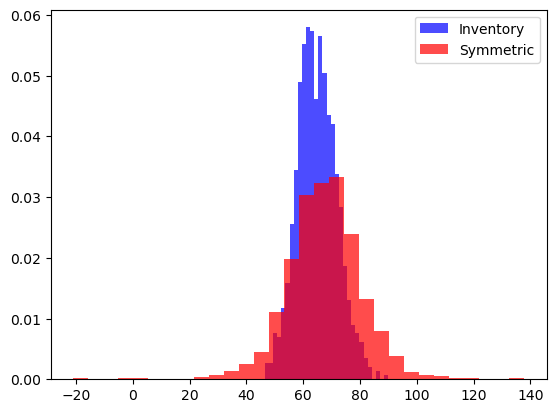

In [57]:
plt.plot(figsize=(18, 10))
plt.hist(all_results[0.1]['inventory']['pnl_values'], bins=30, alpha=0.7, color='blue', label='Inventory', density=True)
plt.hist(all_results[0.1]['symmetric']['pnl_values'], bins=30, alpha=0.7, color='red', label='Symmetric', density=True)
plt.legend()
plt.show()

### Gamma = 0.5

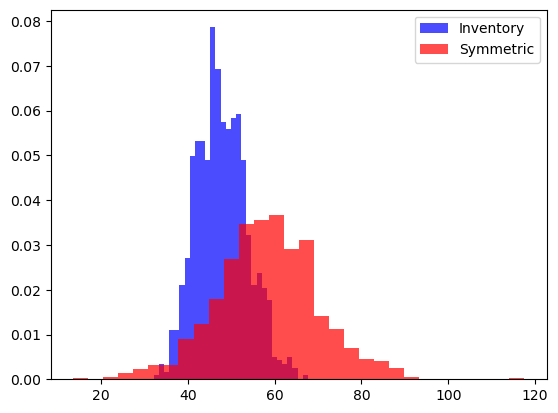

In [62]:
plt.plot(figsize=(18, 10))
plt.hist(all_results[0.5]['inventory']['pnl_values'], bins=30, alpha=0.7, color='blue', label='Inventory', density=True)
plt.hist(all_results[0.5]['symmetric']['pnl_values'], bins=30, alpha=0.7, color='red', label='Symmetric', density=True)
plt.legend()
plt.show()